In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import yfinance as yf
import datetime

from valueinvesting import utils as utils

# 1. Load raw input
## Hardcoded block

In [2]:
evaluate_last_X_years = True
X=10
currency_pair = 'USD=X'
numbers_in_currency = 'USD'
share_name = 'NWL'

# 1.1 Calculate Share numbers from total distributed dividend (CFS) and dividend amount

# 1.2. Raw input statement data

In [3]:
route = f"../data/input/{share_name}_data.csv"
data = pd.read_csv(route, sep=';', parse_dates=['date', 'real_date'])
# replace -, extend missing 0-s, fix datatype
data = utils.replace_format_input(data)

In [4]:
owned_shares = pd.read_csv('../data/extras/owned_stocks.csv', sep=';', parse_dates=['date'])
owned_shares = owned_shares.loc[(owned_shares['stock'] == share_name) & (owned_shares['active'] == 'yes')]

## (OPTIONAL) Time Filtering - Last 7 years daat

In [5]:
if evaluate_last_X_years:
    data = data[data['date'] > datetime.datetime.today() - datetime.timedelta(days=X*366+93)]
    data = data.reset_index(drop=True)

data.head()

,date,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,curr_assets,goodwill,...,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,shares,real_date
0,2014-09-30,1485,-908,577,123,133,1158,789,2377,2440,...,579,517,251,2189,1419,4324,339,-34,278.9,2014-10-27
1,2014-12-31,1526,-952,574,49,199,1248,709,2426,2546,...,674,391,7,1891,2085,4830,291,-61,278.9,2015-02-14
2,2015-03-31,1264,-777,488,57,215,1053,852,2422,2475,...,616,734,7,2045,2094,4909,-154,-51,271.5,2015-04-27
3,2015-06-30,1561,-940,621,148,239,1304,936,2753,2492,...,757,777,6,2307,2081,5179,103,-35,271.5,2015-07-27
4,2015-09-30,1530,-931,599,134,266,1171,899,2586,2496,...,679,631,6,2140,2097,5009,340,-69,271.5,2015-10-27


## Calculate date when quaterly reports could be available

In [6]:
data = utils.calculate_real_date(data)

# 2. Filter out unnecesary columns

In [7]:
data = utils.filter_raw_data(data)
data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,intangible_assets,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex
35,2023-06-30,2023-07-27,414.10,2204,-1549,655,18,317,1285,1937,...,2612,13020,1013,0,597,3060,4753,9705,354,-59
36,2023-09-30,2023-10-27,414.10,2048,-1409,639,-218,396,1212,1778,...,2550,12572,1084,0,376,3019,4737,9446,402,-67
37,2023-12-31,2024-02-14,414.10,2076,-1418,658,-86,332,1195,1531,...,2488,12163,1003,0,329,2897,4575,9051,251,-63
38,2024-03-31,2024-04-27,416.05,1653,-1141,512,-9,372,958,1695,...,2447,12100,1038,0,429,2956,4558,9024,32,-59
39,2024-06-30,2024-07-27,416.05,2033,-1327,706,45,382,1072,1639,...,2412,12048,1079,0,983,3502,4059,8968,32,-53


## Pull historical average USD national currency rates and add to the dataframe

In [8]:
if currency_pair != 'USD=X':
    data['usd_nat_currency'] = utils.daily_price(
        ticker=currency_pair,
        end=data['date'],
        days_earlier=90
        )
else:
    data['usd_nat_currency'] = [1 for x in range(len(data))]

# drop rows, when USD rates wasn't available
data = data[data['usd_nat_currency'].notna()]

data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
35,2023-06-30,2023-07-27,414.10,2204,-1549,655,18,317,1285,1937,...,13020,1013,0,597,3060,4753,9705,354,-59,1
36,2023-09-30,2023-10-27,414.10,2048,-1409,639,-218,396,1212,1778,...,12572,1084,0,376,3019,4737,9446,402,-67,1
37,2023-12-31,2024-02-14,414.10,2076,-1418,658,-86,332,1195,1531,...,12163,1003,0,329,2897,4575,9051,251,-63,1
38,2024-03-31,2024-04-27,416.05,1653,-1141,512,-9,372,958,1695,...,12100,1038,0,429,2956,4558,9024,32,-59,1
39,2024-06-30,2024-07-27,416.05,2033,-1327,706,45,382,1072,1639,...,12048,1079,0,983,3502,4059,8968,32,-53,1


## Convert USD values related to IS, BS, CFS to national currency

In [9]:
# convert columns into national currency if necessary
if numbers_in_currency == 'USD':
    data_nat_curr = utils.convert_national_currency(input_data=data, currency=data)
else:
    data_nat_curr = data.copy()
data_nat_curr.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
35,2023-06-30,2023-07-27,414.10,2204.0,-1549.0,655.0,18.0,317.0,1285.0,1937.0,...,13020.0,1013.0,0.0,597.0,3060.0,4753.0,9705.0,354.0,-59.0,1
36,2023-09-30,2023-10-27,414.10,2048.0,-1409.0,639.0,-218.0,396.0,1212.0,1778.0,...,12572.0,1084.0,0.0,376.0,3019.0,4737.0,9446.0,402.0,-67.0,1
37,2023-12-31,2024-02-14,414.10,2076.0,-1418.0,658.0,-86.0,332.0,1195.0,1531.0,...,12163.0,1003.0,0.0,329.0,2897.0,4575.0,9051.0,251.0,-63.0,1
38,2024-03-31,2024-04-27,416.05,1653.0,-1141.0,512.0,-9.0,372.0,958.0,1695.0,...,12100.0,1038.0,0.0,429.0,2956.0,4558.0,9024.0,32.0,-59.0,1
39,2024-06-30,2024-07-27,416.05,2033.0,-1327.0,706.0,45.0,382.0,1072.0,1639.0,...,12048.0,1079.0,0.0,983.0,3502.0,4059.0,8968.0,32.0,-53.0,1


# 3. Calculate input to Value Raios (eps, bv per share, fcf)
## filter out unwanted columns

In [10]:
filtered_nat_curr = utils.calculate_input_value_ratios(data_nat_curr)

## Calculate input values to value ratios

In [11]:
ratios_nat_curr = utils.ratios_input_filter(filtered_nat_curr)

## Calculate performance parameters (current ratio, ROA, ROE, margins, D/E)

In [12]:
ratios_nat_curr = utils.evaluate_performance(input=filtered_nat_curr, output=ratios_nat_curr)

# 4. Pull historical share prices and merge with sattement data

In [13]:
# pull weekly share prices and merge with the value ratios
merged_nat_curr = utils.add_share_prices_to_value_ratios(share_name, data, ratios_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,equity_ratio,debt_ratio,acc_rec_ratio,acc_pay_ratio,cash_turnover,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe
0,2014-10-27,22.943932,2014-09-30,1485.0,0.0,7.260667,278.9,0.0,0.0,133.0,...,0.318948,0.681052,0.0,0.0,0.0,0.0,0.388552,0.082828,0.0,0.0
1,2014-11-03,23.955856,2014-09-30,1485.0,0.0,7.260667,278.9,0.0,0.0,133.0,...,0.318948,0.681052,0.0,0.0,0.0,0.0,0.388552,0.082828,0.0,0.0
2,2014-11-10,23.976505,2014-09-30,1485.0,0.0,7.260667,278.9,0.0,0.0,133.0,...,0.318948,0.681052,0.0,0.0,0.0,0.0,0.388552,0.082828,0.0,0.0
3,2014-11-17,24.740606,2014-09-30,1485.0,0.0,7.260667,278.9,0.0,0.0,133.0,...,0.318948,0.681052,0.0,0.0,0.0,0.0,0.388552,0.082828,0.0,0.0
4,2014-11-24,24.995321,2014-09-30,1485.0,0.0,7.260667,278.9,0.0,0.0,133.0,...,0.318948,0.681052,0.0,0.0,0.0,0.0,0.388552,0.082828,0.0,0.0


# Calculate price ratios (P/E, P/B, P/S, P/FCF)

In [14]:
merged_nat_curr = utils.price_ratios(merged_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,pfcf_ratio
0,2014-10-27,22.943932,2014-09-30,1485.0,0.0,7.260667,278.9,0.0,0.0,133.0,...,0.0,0.388552,0.082828,0.0,0.0,inf,3.160031,inf,inf,inf
1,2014-11-03,23.955856,2014-09-30,1485.0,0.0,7.260667,278.9,0.0,0.0,133.0,...,0.0,0.388552,0.082828,0.0,0.0,inf,3.299402,inf,inf,inf
2,2014-11-10,23.976505,2014-09-30,1485.0,0.0,7.260667,278.9,0.0,0.0,133.0,...,0.0,0.388552,0.082828,0.0,0.0,inf,3.302246,inf,inf,inf
3,2014-11-17,24.740606,2014-09-30,1485.0,0.0,7.260667,278.9,0.0,0.0,133.0,...,0.0,0.388552,0.082828,0.0,0.0,inf,3.407484,inf,inf,inf
4,2014-11-24,24.995321,2014-09-30,1485.0,0.0,7.260667,278.9,0.0,0.0,133.0,...,0.0,0.388552,0.082828,0.0,0.0,inf,3.442565,inf,inf,inf


# Calculate Dividend yield and currency-share price correlation

In [15]:
# get daily historical USD-national currency rates
usd_nat_curr = utils.get_historical_currency_rate(currency_pair, merged_nat_curr)

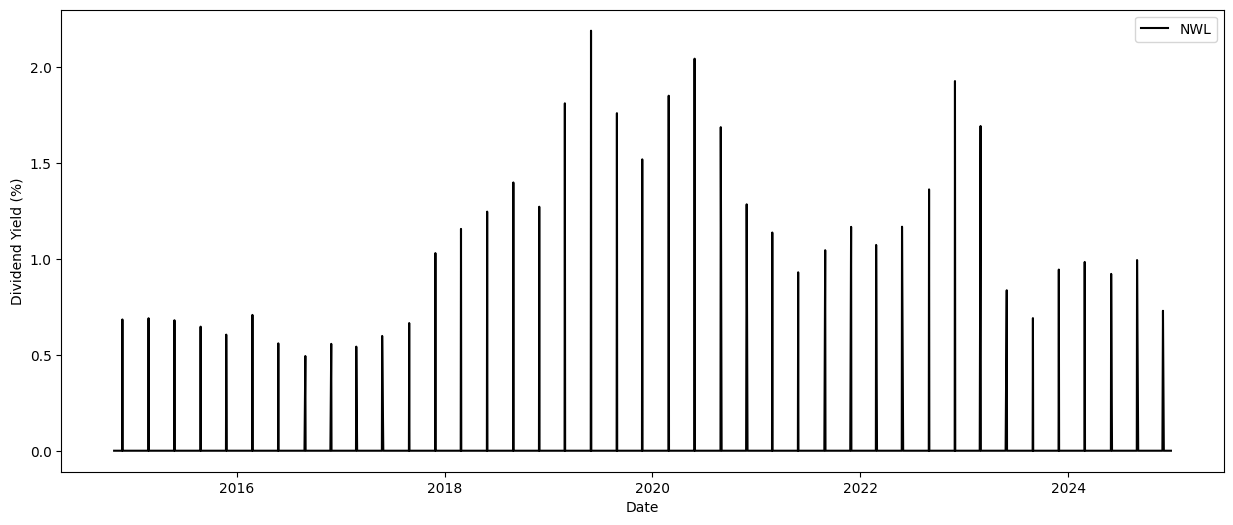

In [16]:
# get share prices and dividend yield data
ticker_all_price = utils.get_historical_share_dividend(share_name, merged_nat_curr)

currency_rate   NaN
share_price     NaN
Name: share_price, dtype: float64


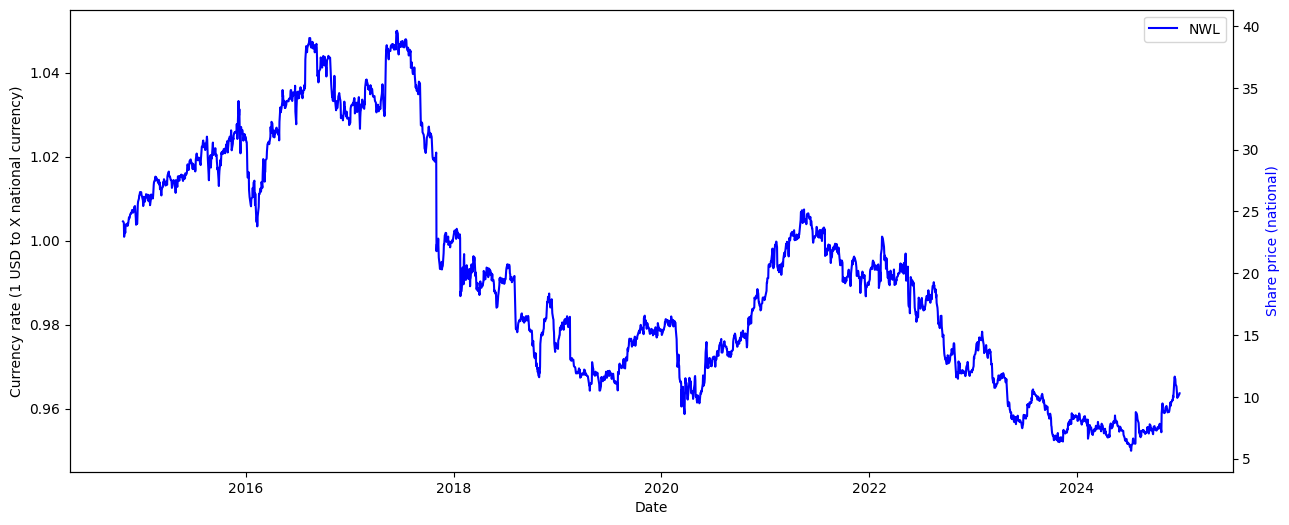

In [17]:
# Pearson's correlation coefficient between share price and USD - national currency rate
utils.get_currency_share_price_correlation(share_name, usd_nat_curr, ticker_all_price)

# Share price and value ratios

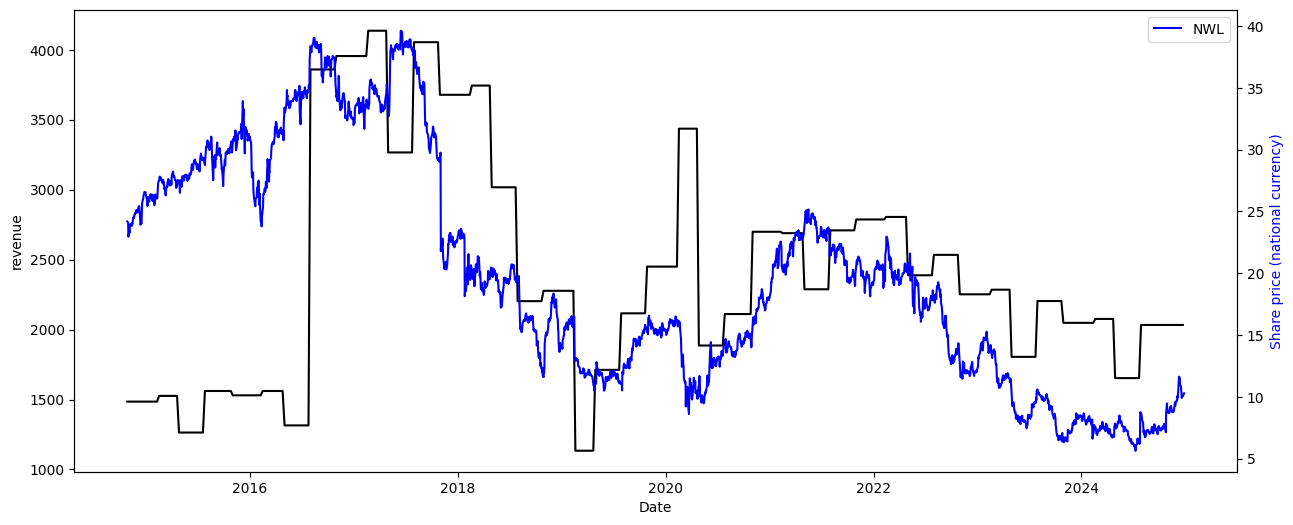

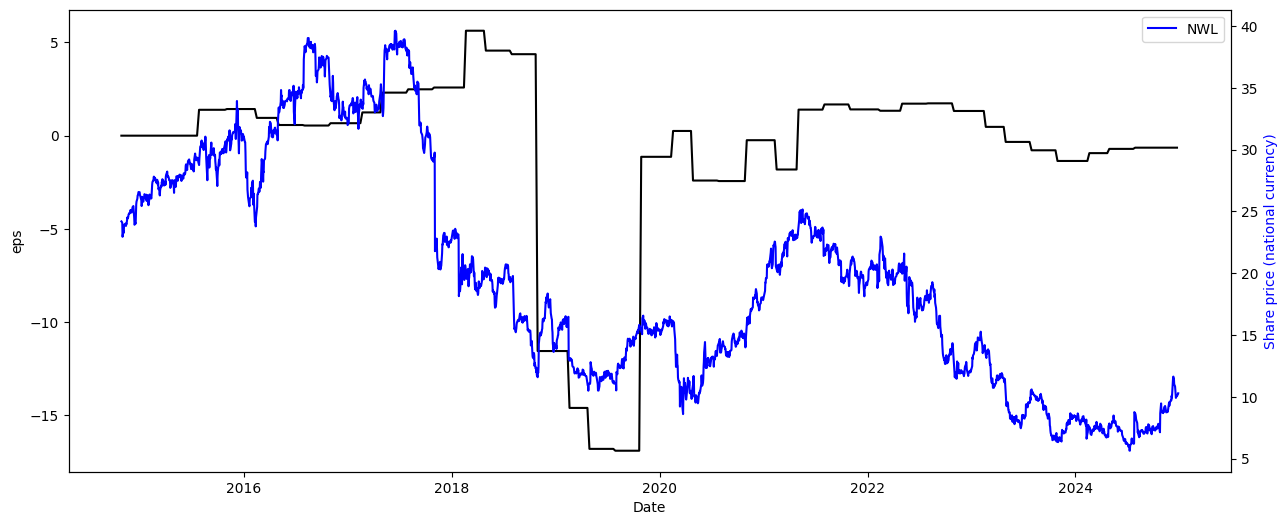

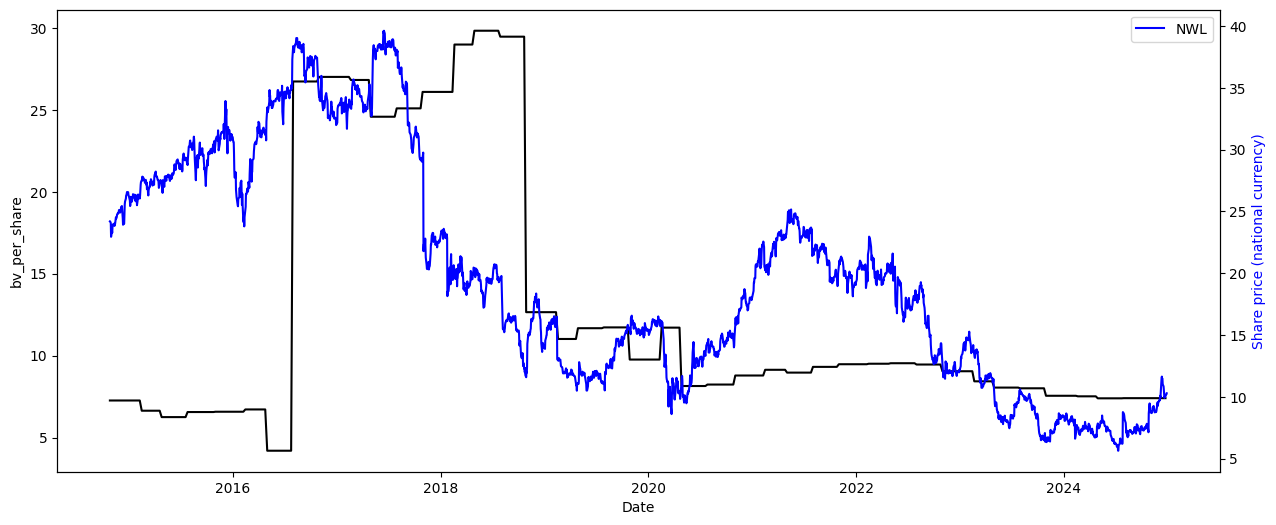

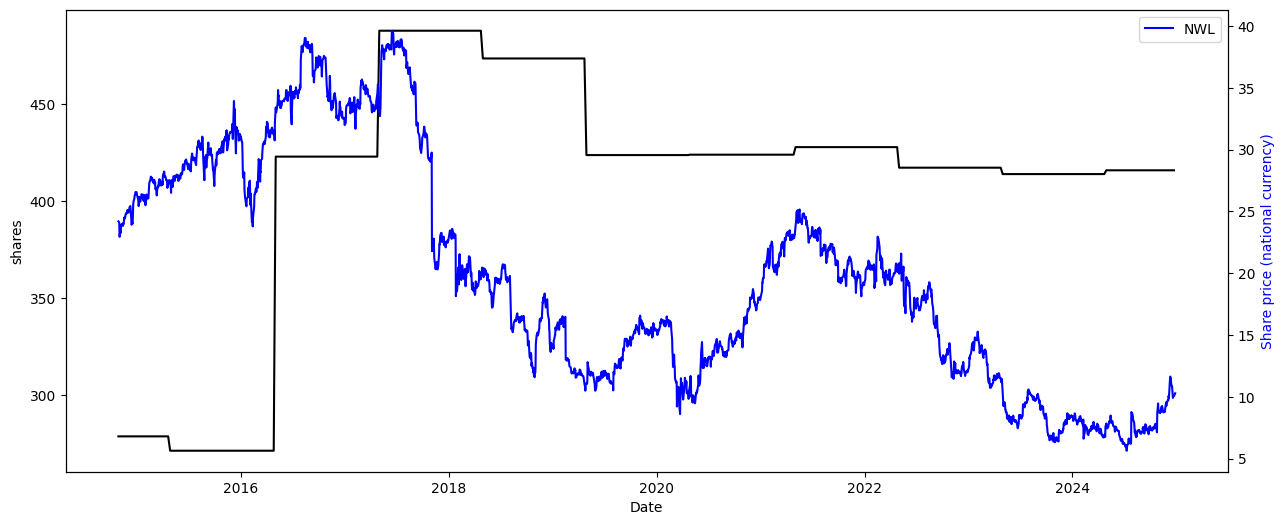

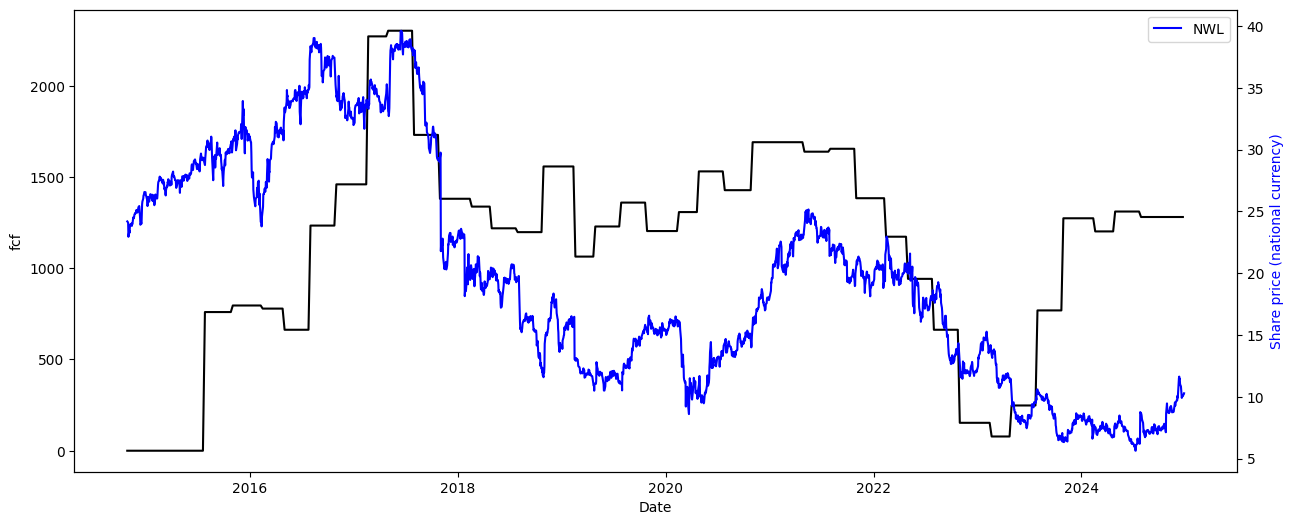

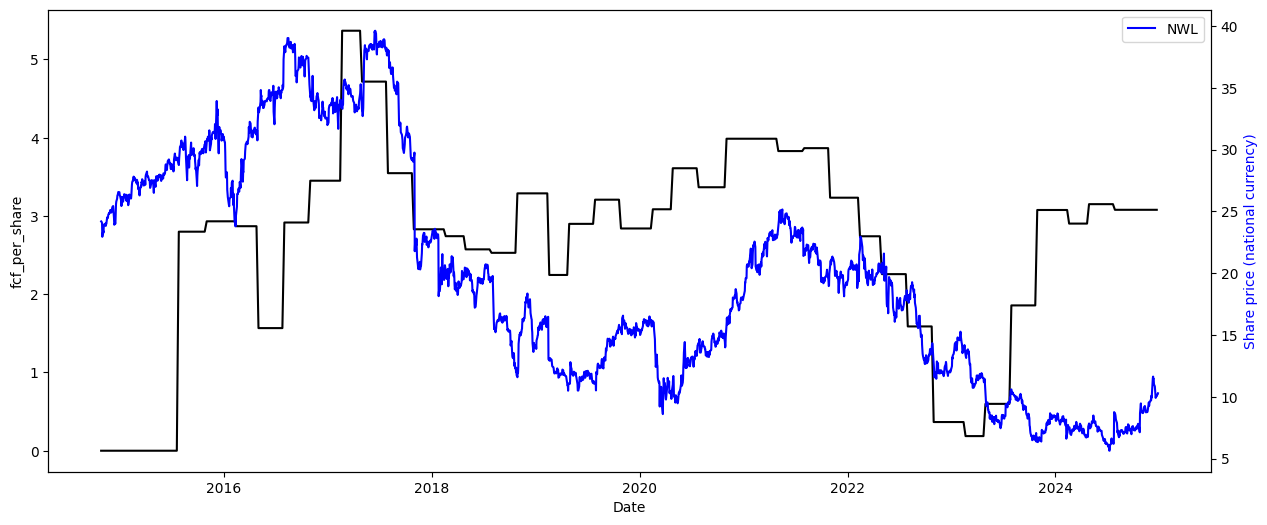

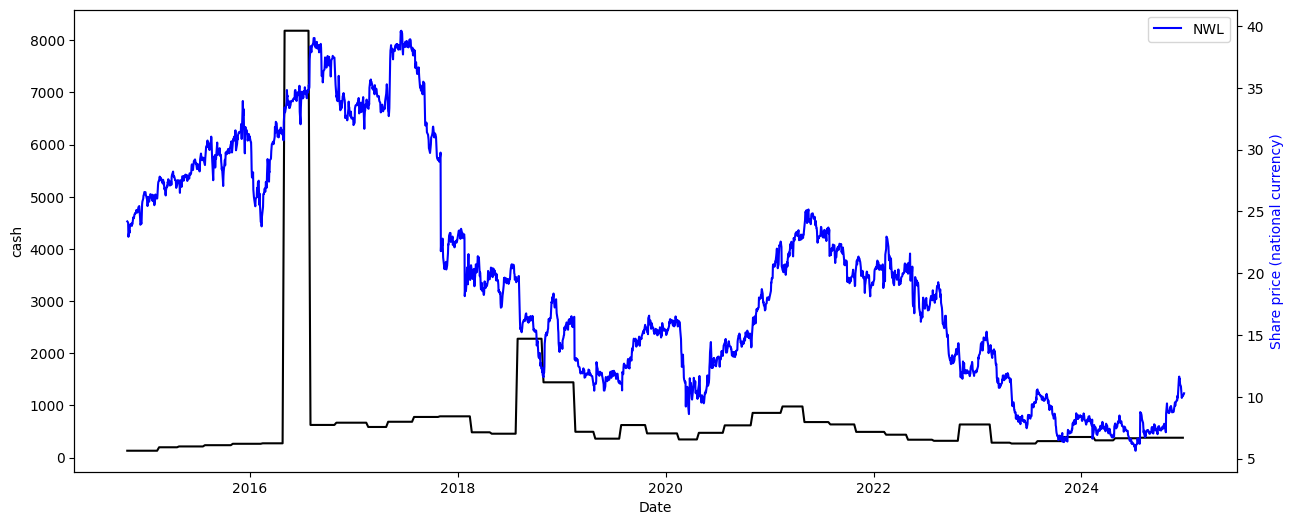

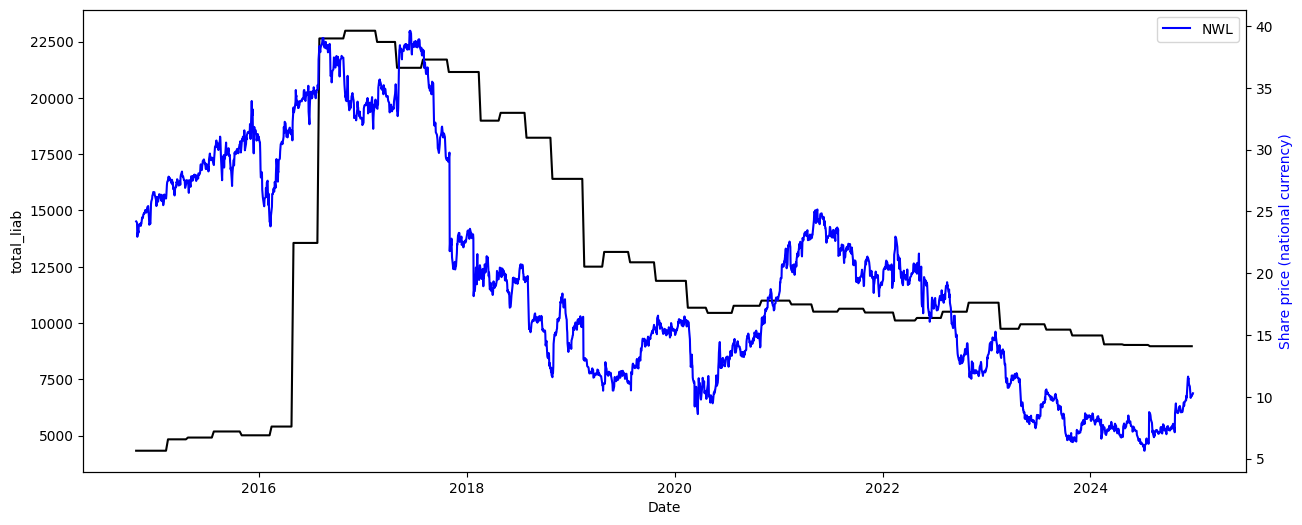

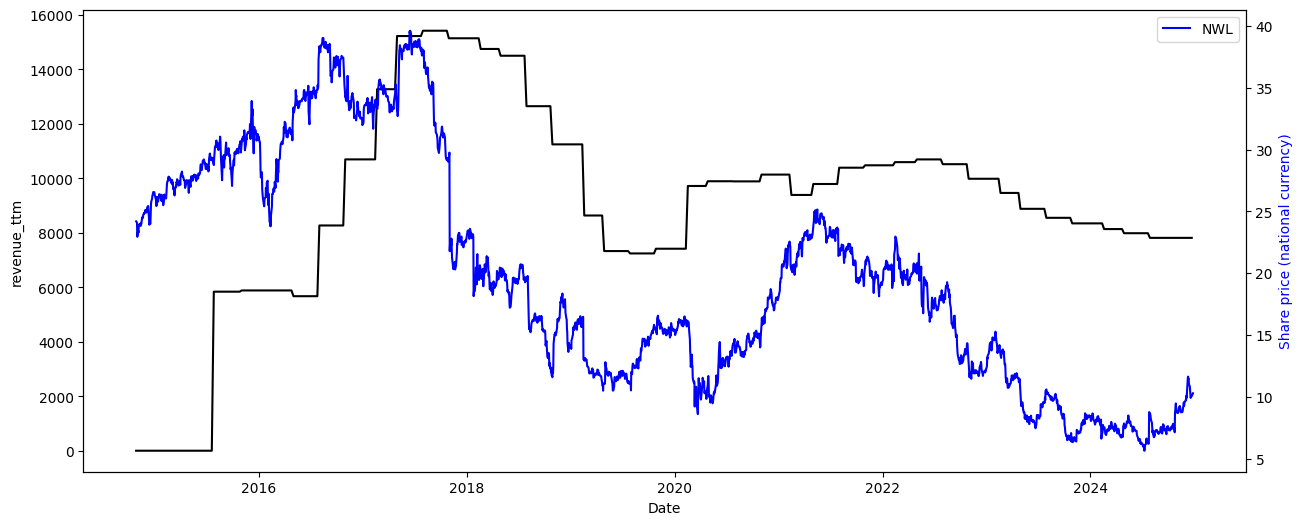

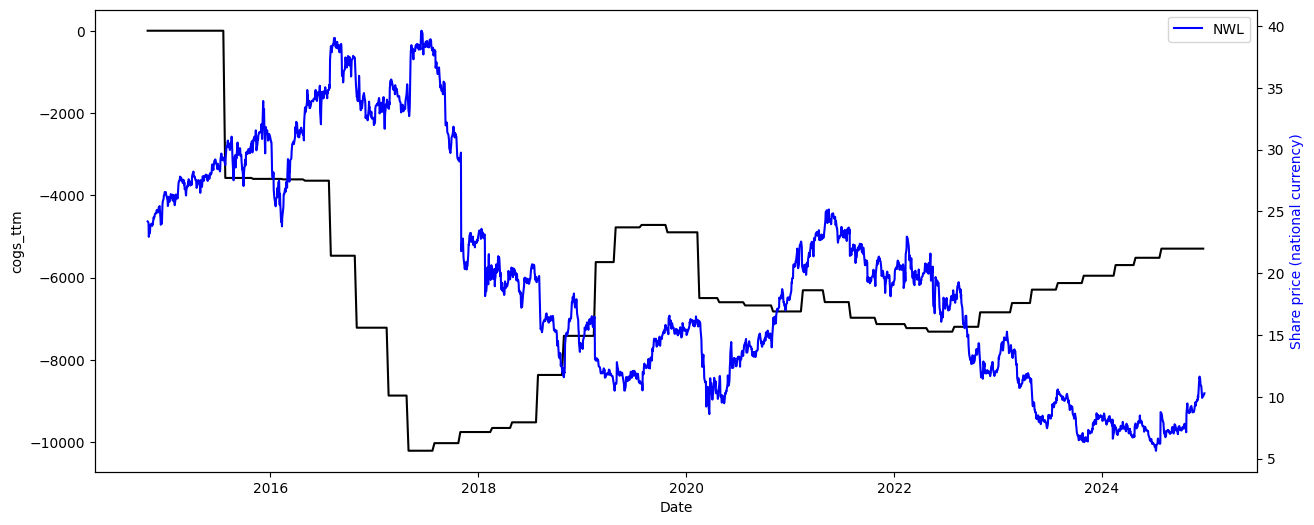

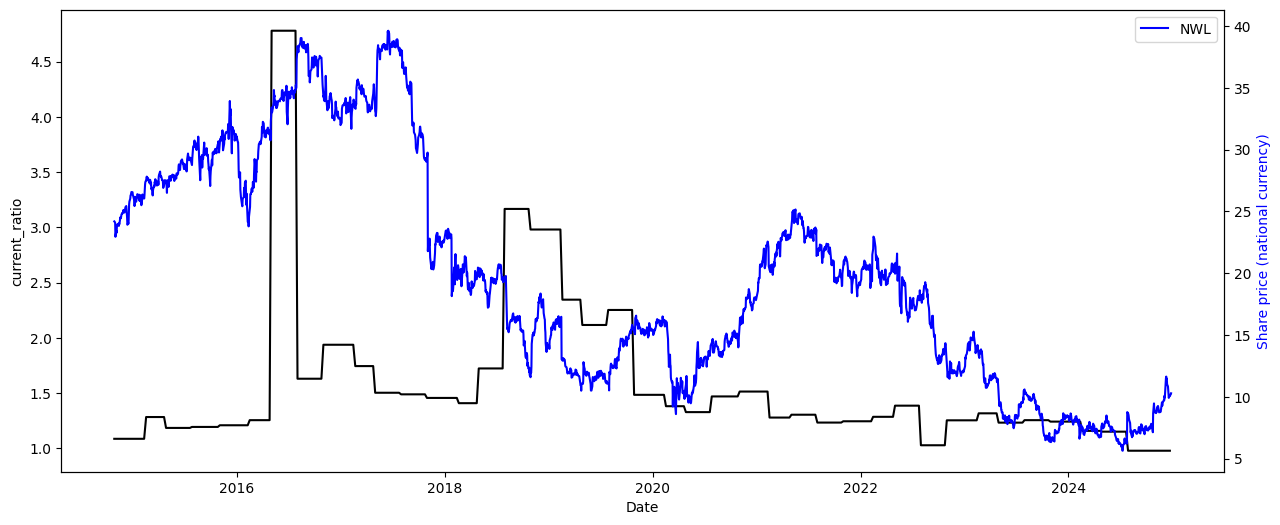

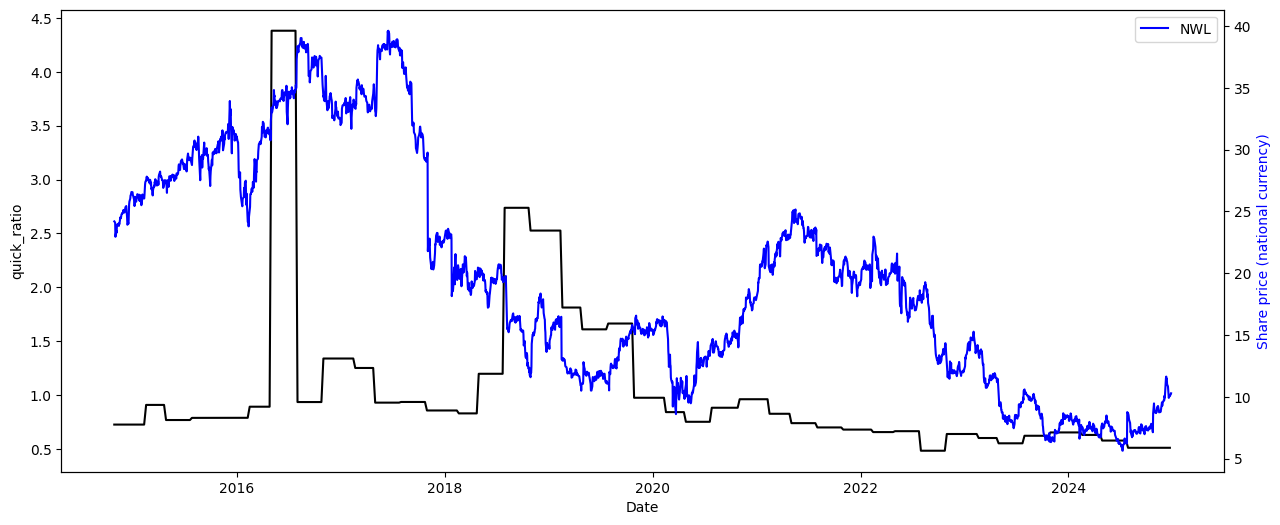

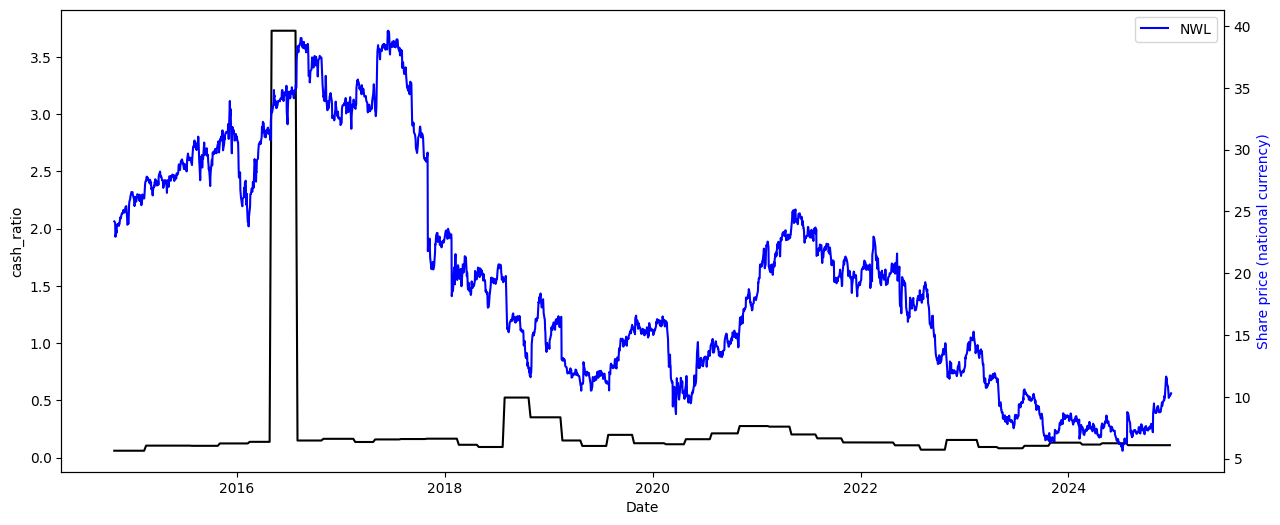

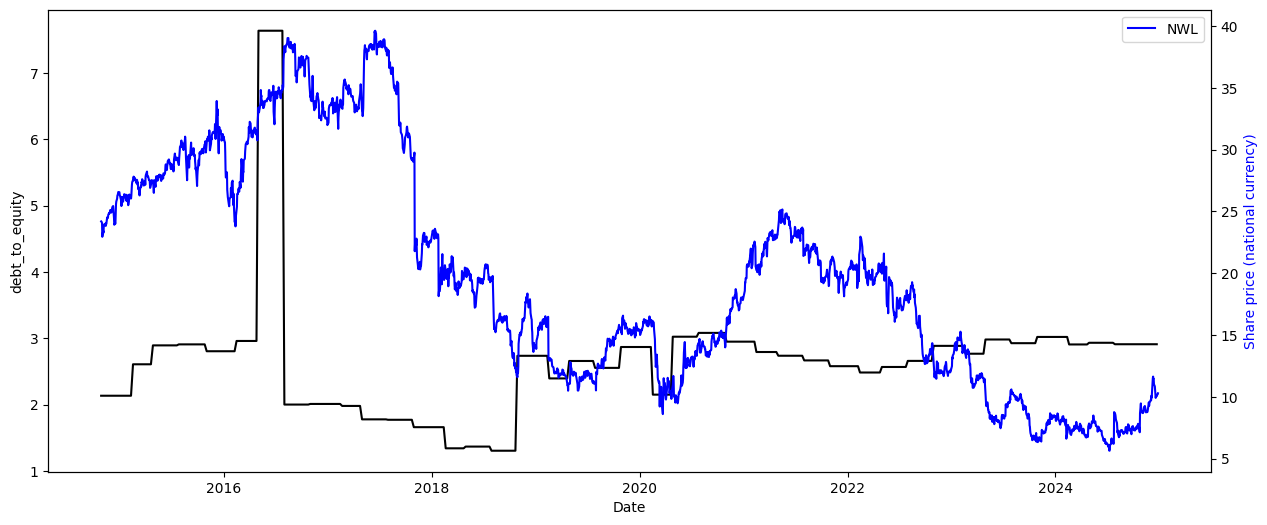

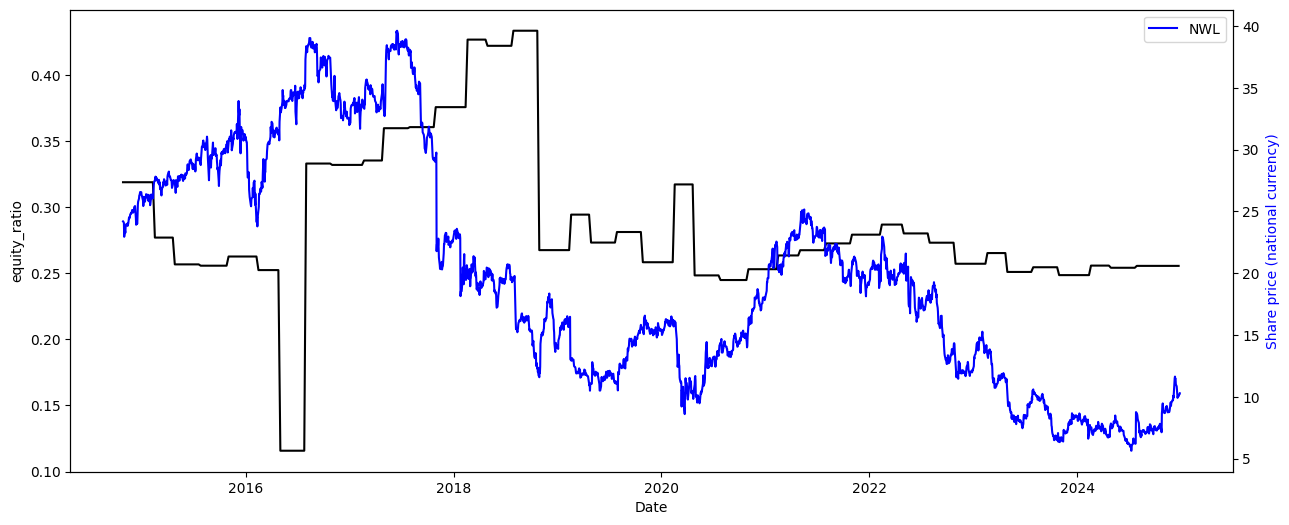

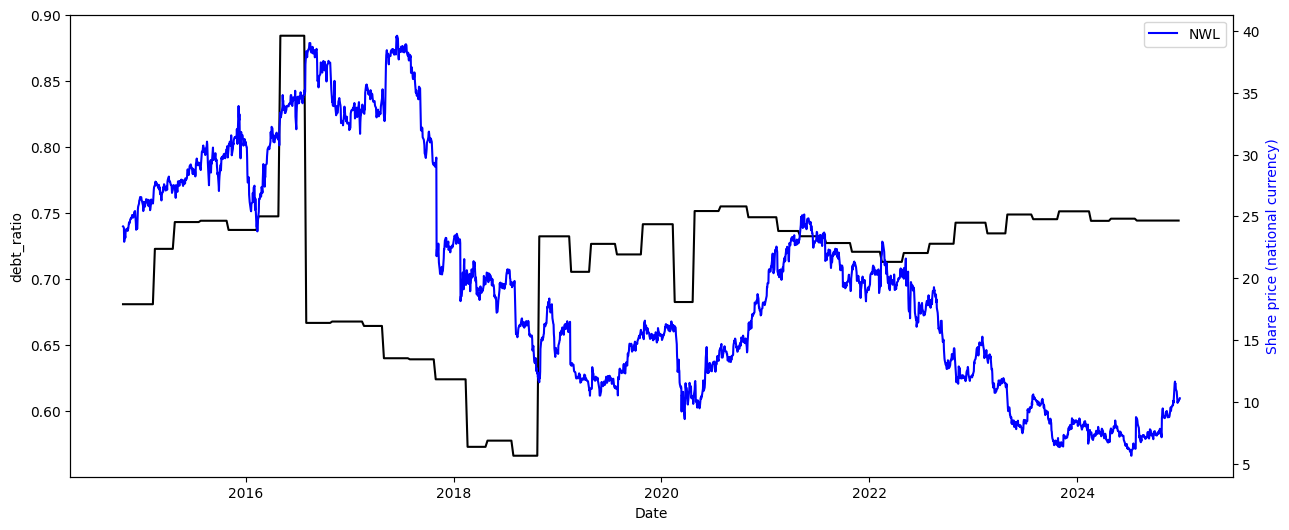

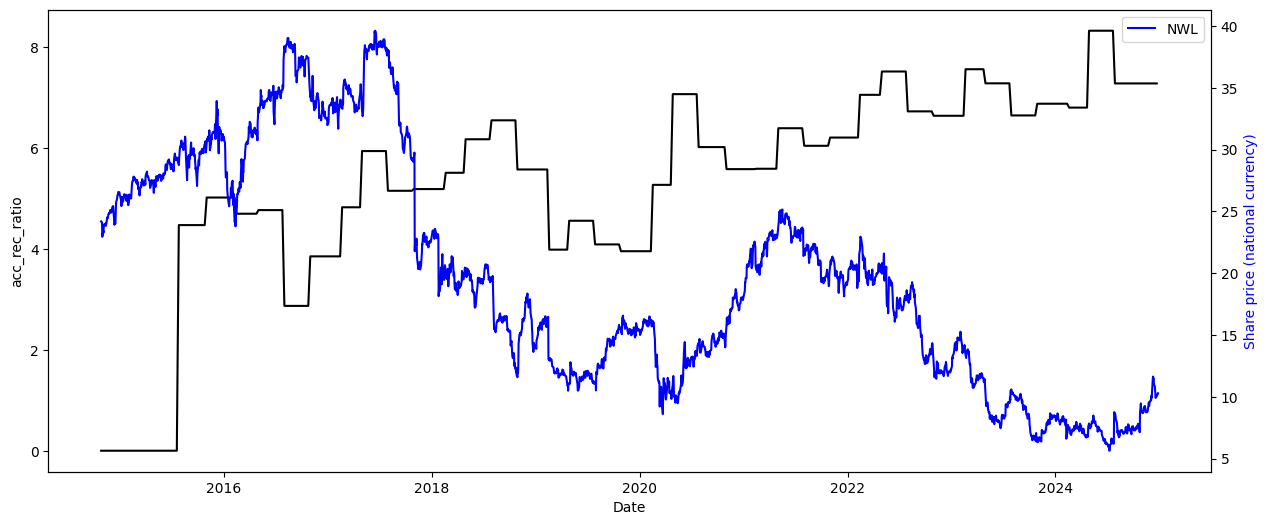

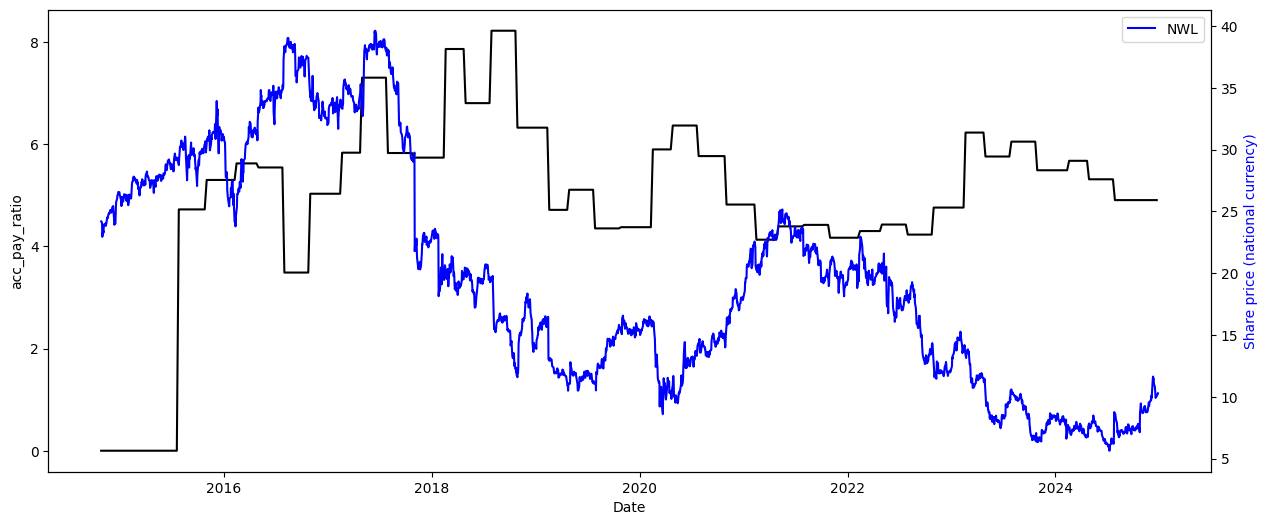

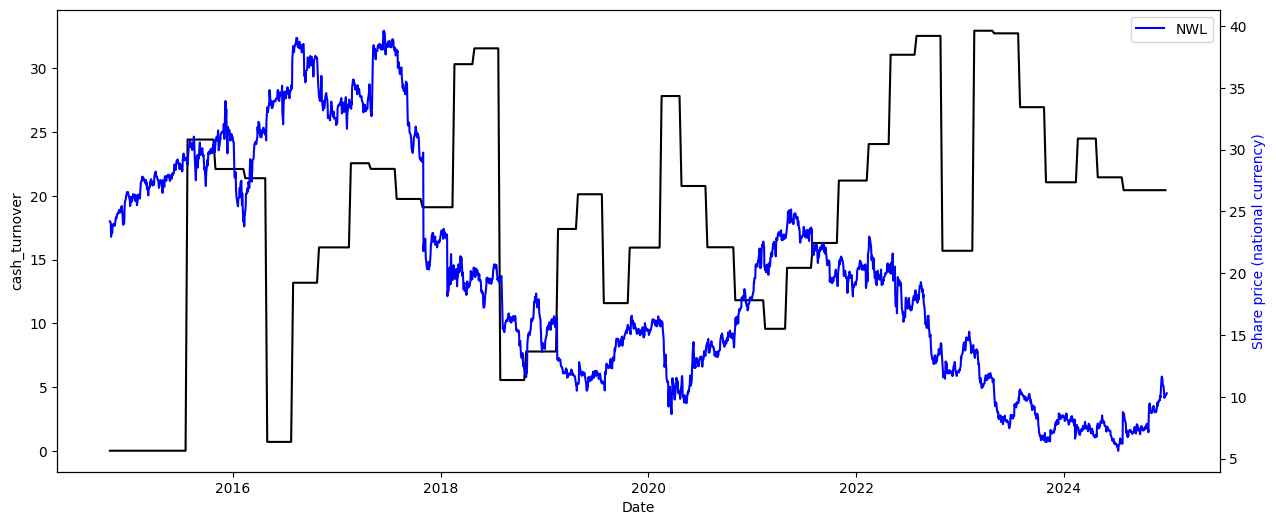

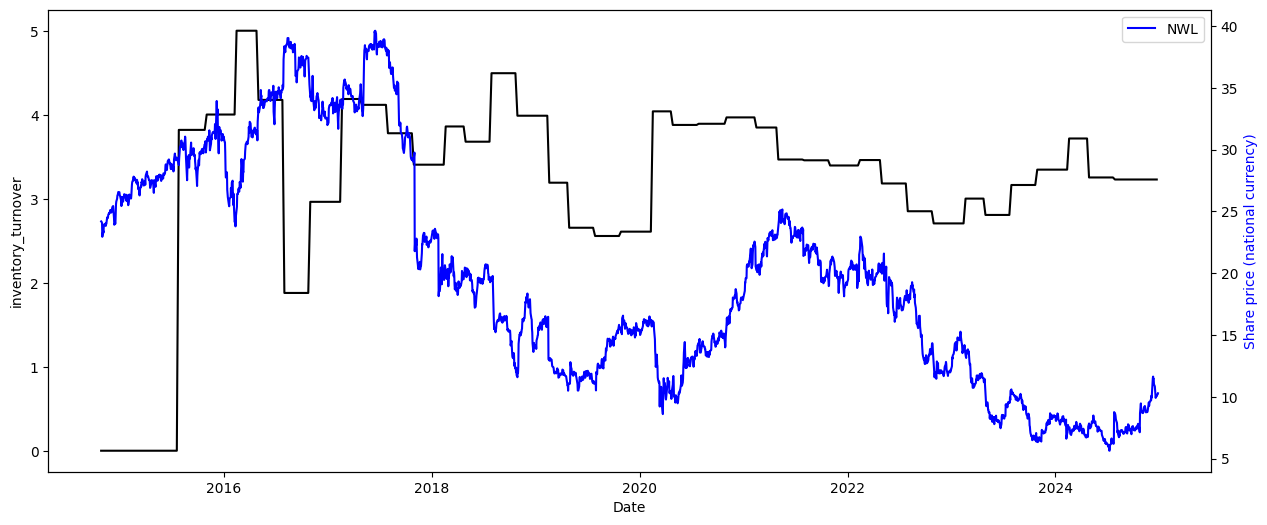

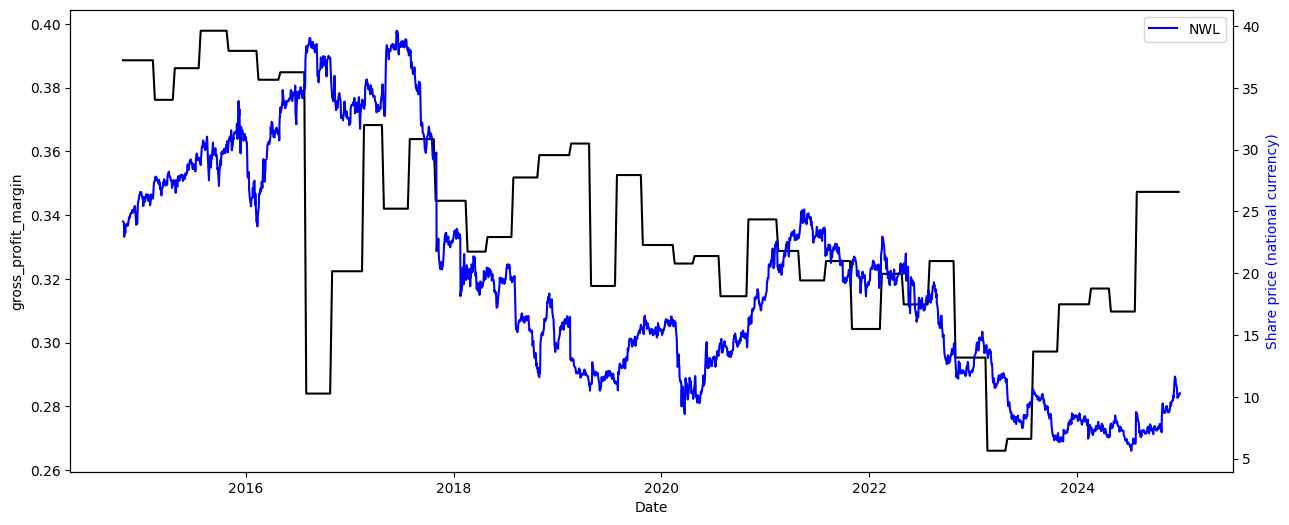

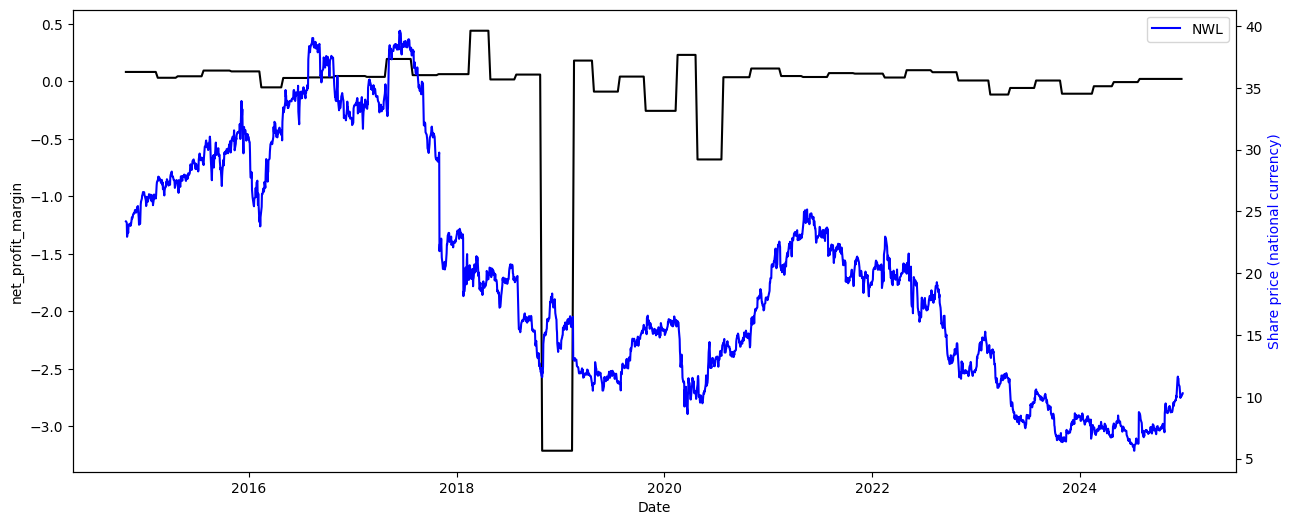

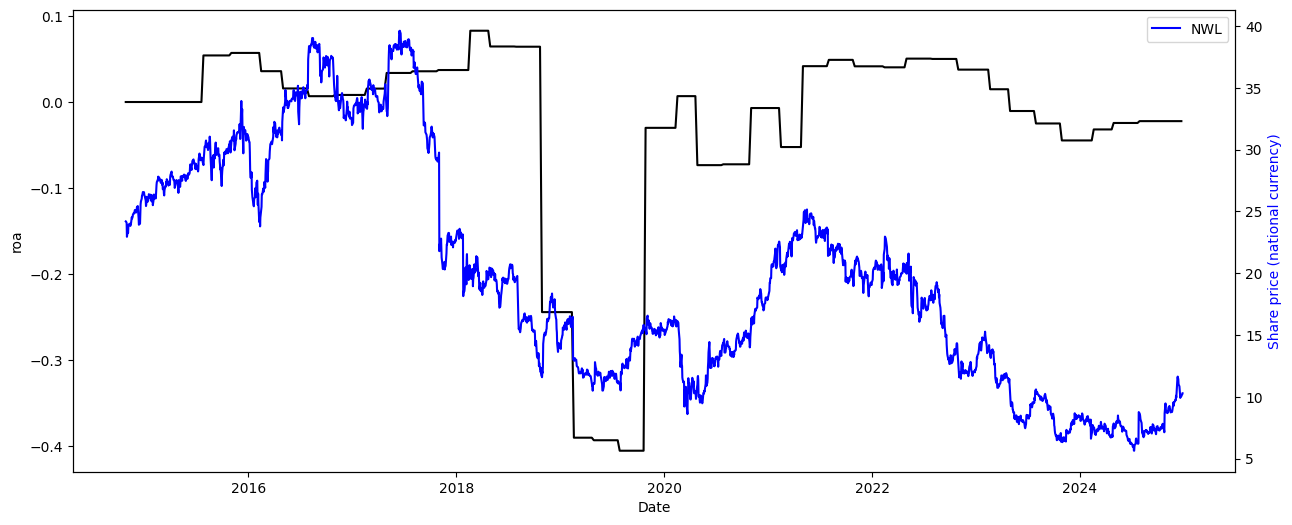

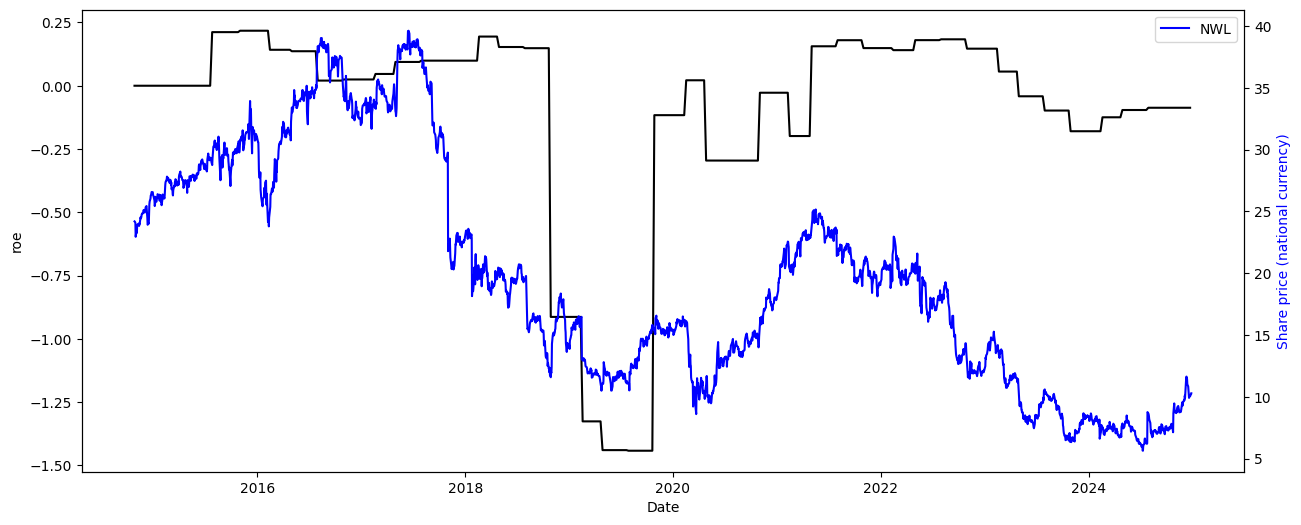

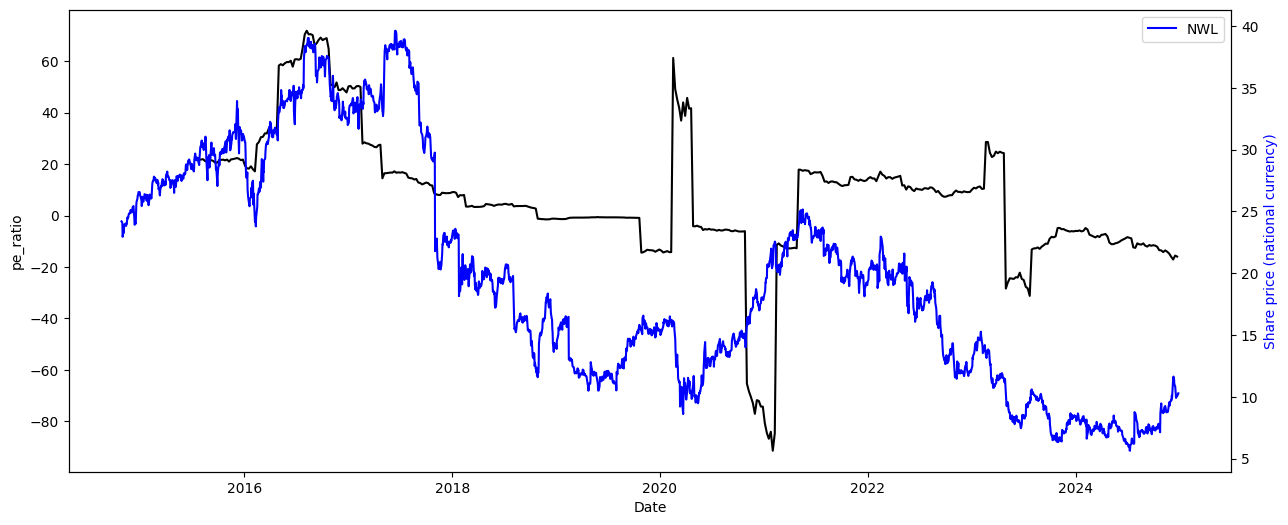

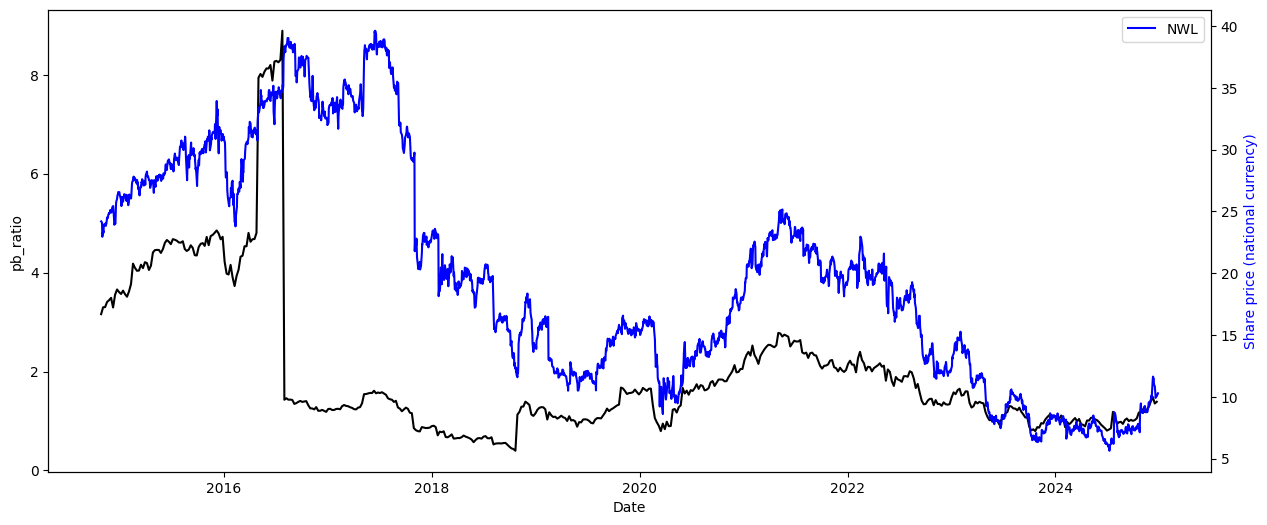

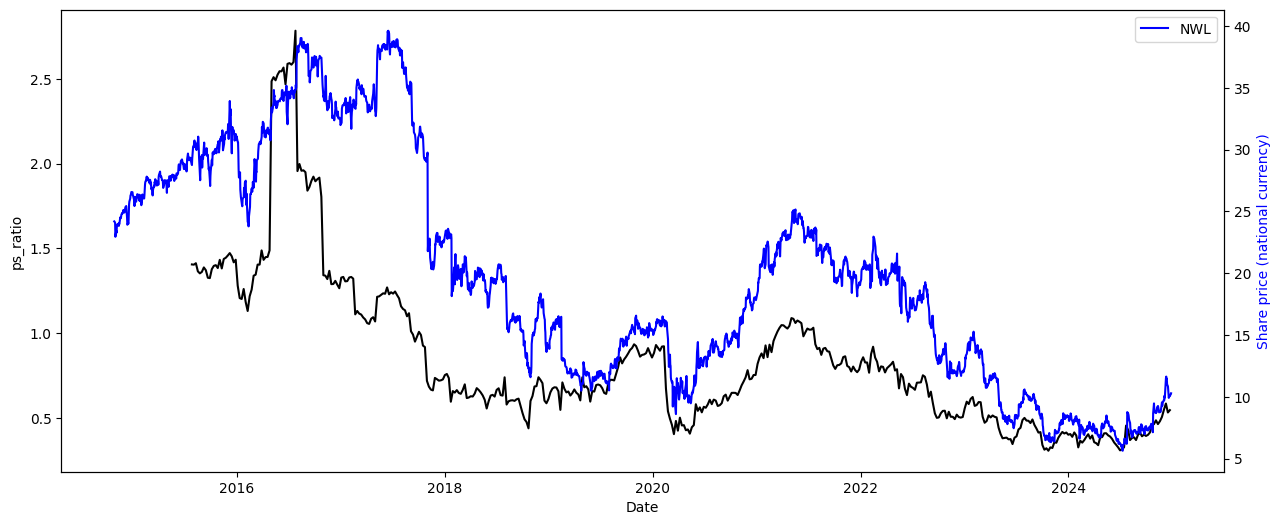

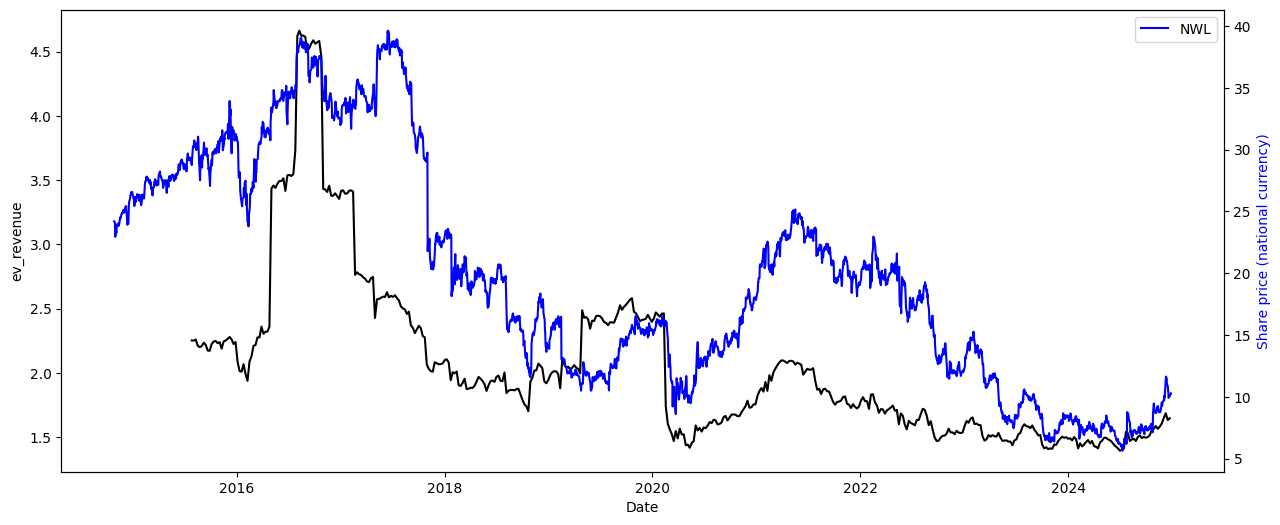

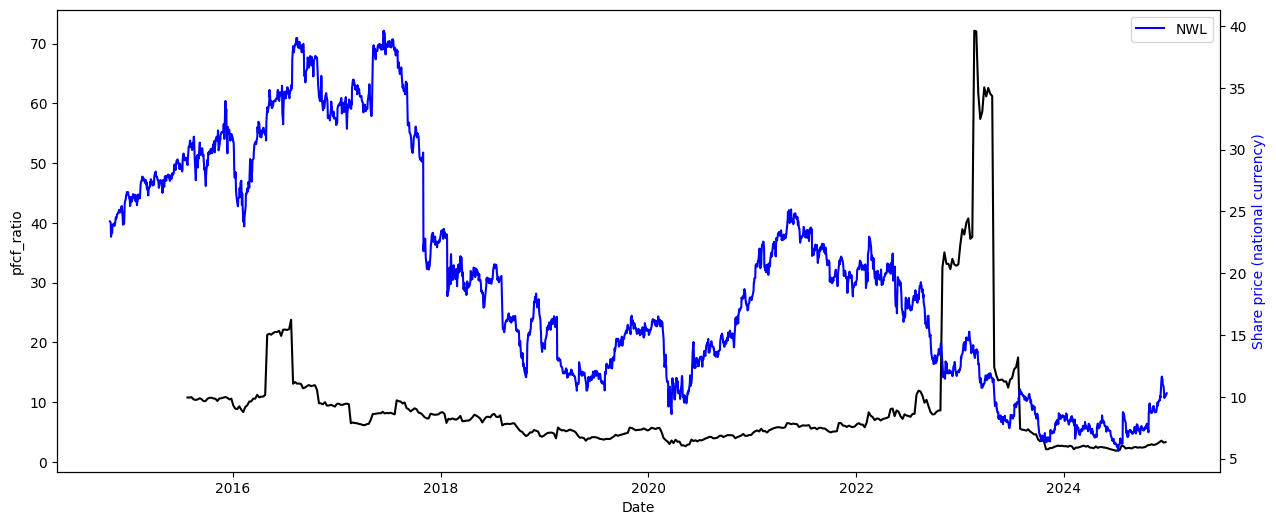

In [18]:
for column in merged_nat_curr.columns[3:]:
    fig, ax1 = plt.subplots(figsize=(15, 6))

    ax2 = ax1.twinx()
    ax1.plot(merged_nat_curr['real_date'], merged_nat_curr[column], color='k', label=merged_nat_curr)
    ax2.plot(ticker_all_price.index, ticker_all_price['Close'], color='b', label=share_name)

    ax1.set_xlabel('Date')
    ax1.set_ylabel(column, color='k')
    ax2.set_ylabel('Share price (national currency)', color='b')

    plt.legend()
    plt.show()

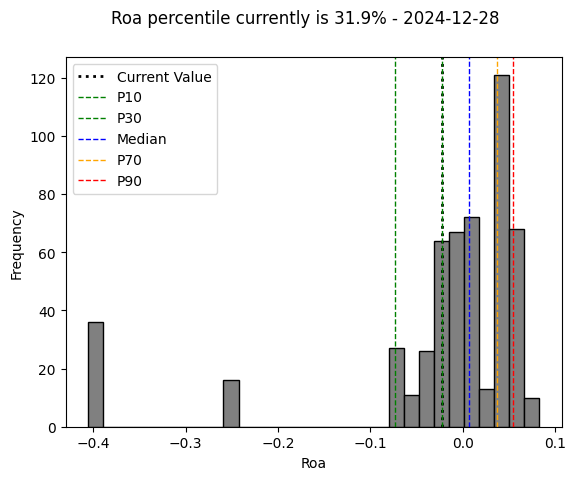

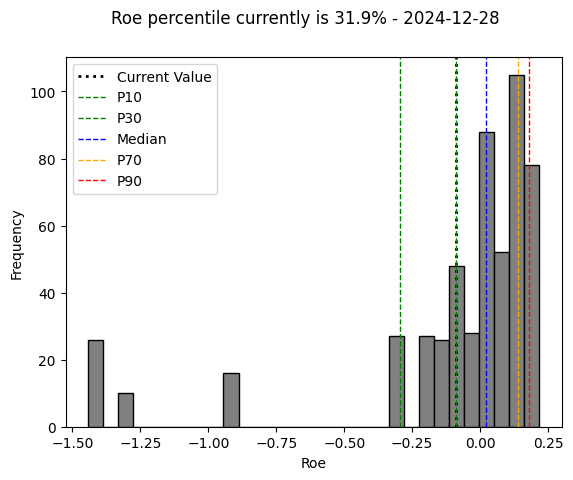

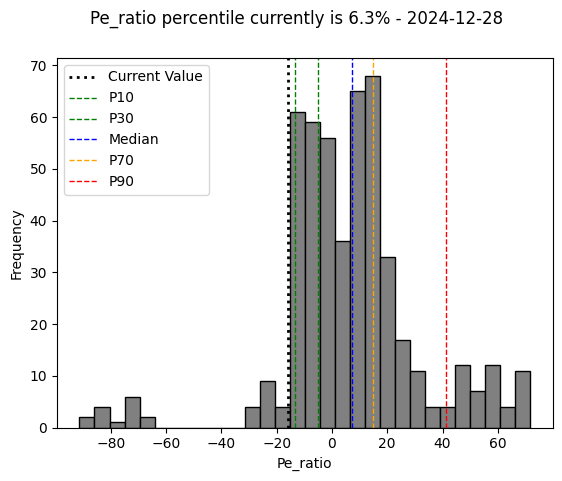

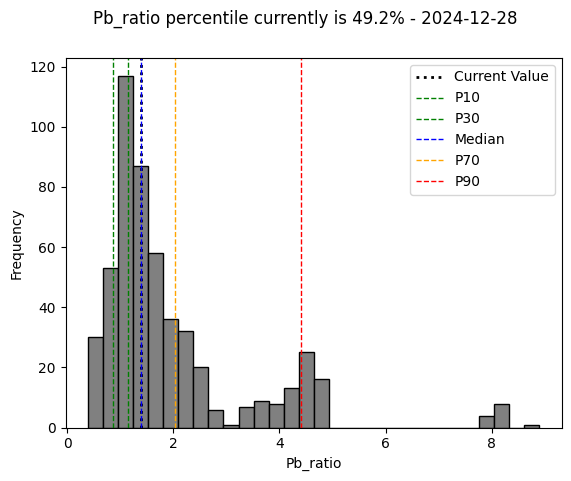

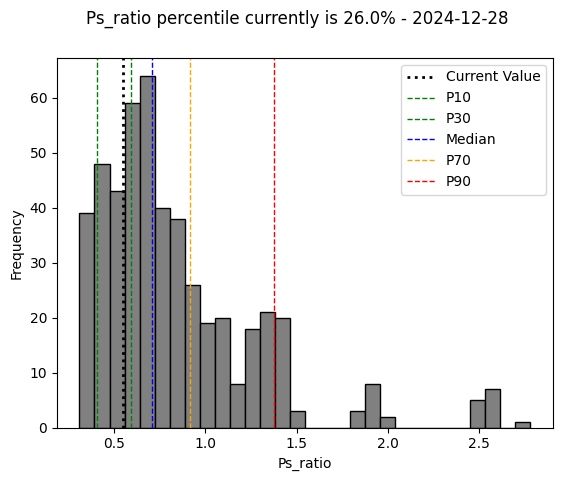

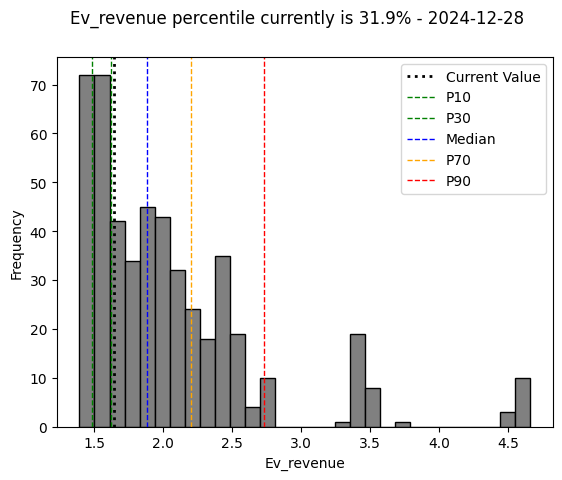

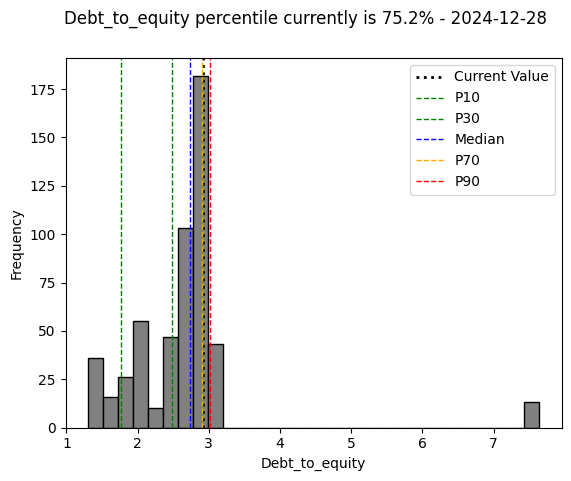

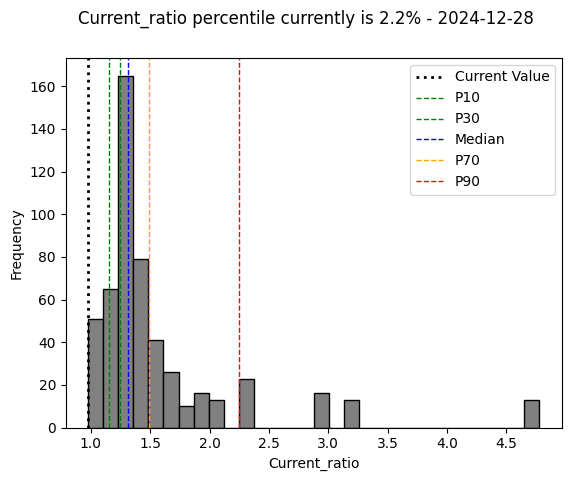

In [19]:
# plot histograms of value parameters
utils.plot_histogram_value_parameters(input_df=merged_nat_curr, extra_parameters=[], owned_shares=owned_shares)

## Calculate correlation between value parameters

In [20]:
# calulate value parameters Pearson's correlation coefficient
pd.DataFrame(merged_nat_curr, columns=['roa', 'roe', 'pe_ratio', 'pb_ratio', 'ps_ratio', 'ev_revenue', 'debt_to_equity', 'current_ratio']).corr()

,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,debt_to_equity,current_ratio
roa,1.000000,0.997278,0.214632,0.215787,0.177692,-0.054301,-0.070216,-0.315533
roe,0.997278,1.000000,0.234486,0.261789,0.212244,-0.038496,-0.022622,-0.307784
pe_ratio,0.214632,0.234486,1.000000,0.352444,0.633448,0.627551,0.098819,0.278900
pb_ratio,0.215787,0.261789,0.352444,1.000000,0.769045,0.325646,0.685624,0.286305
ps_ratio,0.177692,0.212244,0.633448,0.769045,1.000000,0.838063,0.438215,0.478294
ev_revenue,-0.054301,-0.038496,0.627551,0.325646,0.838063,1.000000,0.113821,0.449020
debt_to_equity,-0.070216,-0.022622,0.098819,0.685624,0.438215,0.113821,1.000000,0.470331
current_ratio,-0.315533,-0.307784,0.278900,0.286305,0.478294,0.449020,0.470331,1.000000


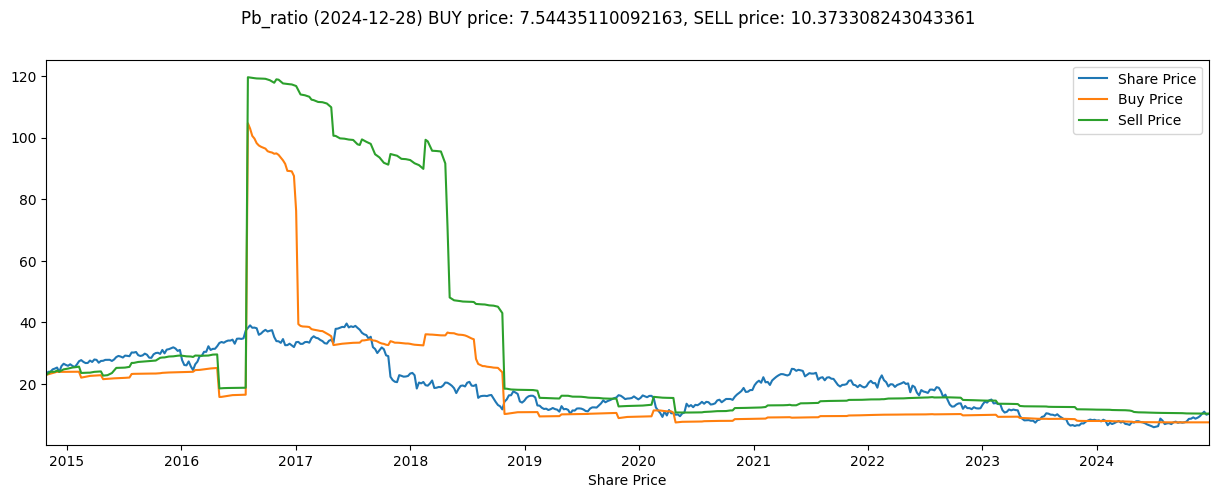

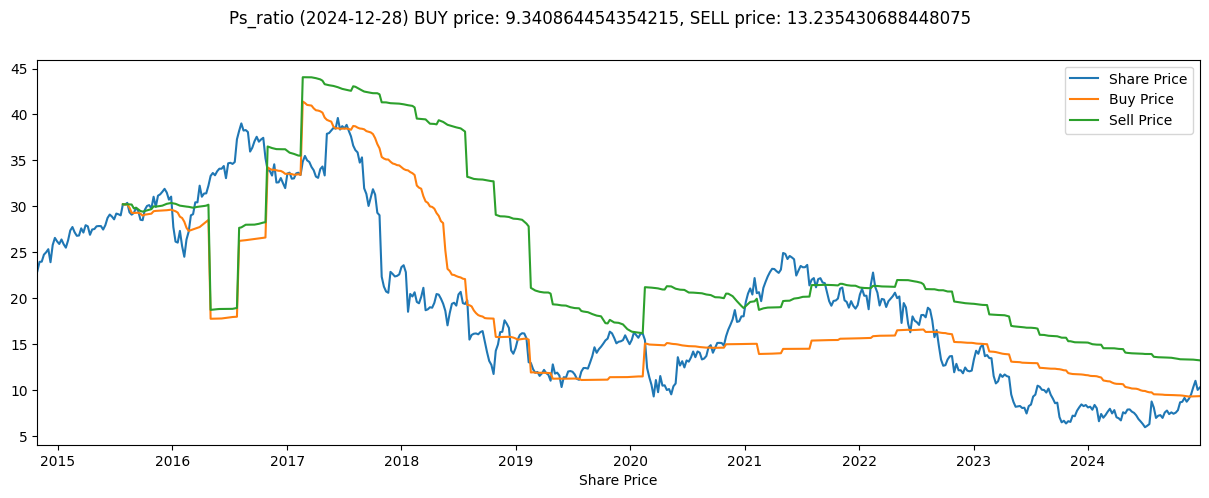

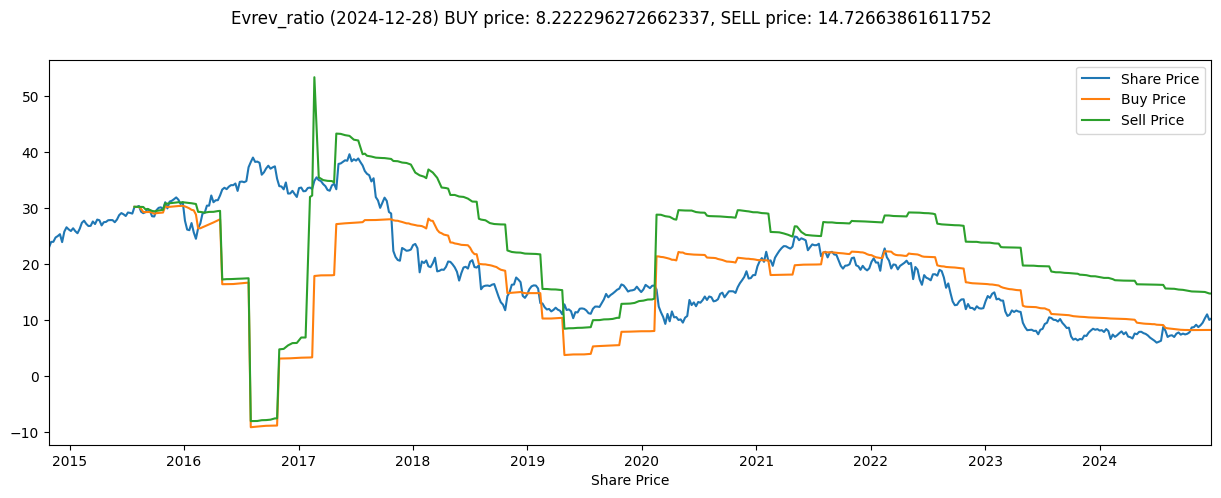

In [21]:
final_df = utils.get_value_stock_target_prices(
    input_df=merged_nat_curr,
    min_pct=0.2,
    max_pct=0.5,
    owned_shares=owned_shares
)